Utilizzo di pynetlogo per una singola simulazione.

È una pessima idea lanciare run all.

In [1]:
import pynetlogo
import numpy as np
import matplotlib.pyplot as plt
import json
#import networkx as nx

%matplotlib widget

### Impostazioni

In [2]:
outputdir = './outputs/update1/sim0/' # directory dove salvare config e output

nl_gui = True           # false per non far partire la gui di netlogo
nl_model = "./EC.nlogo" # modello da caricare in netlogo

Runnare una delle due celle seguenti in base a se vuoi cambiare variabili o caricarle da un file

In [3]:
# CARICAMENTO VARIABILI DA FILE
with open(outputdir+"global_vars.json",'r') as f:
  global_vars = json.load(f)

print(global_vars)

{'N': 1000, 'beta': 0.8, 'mutrue': 0.0, 'vartrue': 1.0, 'update-type': 1, 'var-c': 0.25, 'var-d': 2}


In [6]:
# IMPOSTAZIONE VARIABILI GLOBALI DA PYTHON e salvataggio nel file
global_vars = {
  'N': 1000,
  'beta': 0.8,
  'mutrue': 0.,
  'vartrue': 1.,
  'update-type': 1,
  'var-c': 0.25,
  'var-d': 2
}

with open(outputdir+"global_vars.json",'x') as f:
  f.write(json.dumps(global_vars,indent=2))

### Simulazione singola

#### Caricamento netlogo

In [4]:
## perché funzioni: installato tutto da conda tranne pynetlogo, installato per ultimo
## java-21-openjdk
import sys
if (sys.platform == 'linux') :
    netlogo = pynetlogo.NetLogoLink(
        gui=nl_gui,
        netlogo_home="/opt/netlogo/",
    )
else:
    netlogo = pynetlogo.NetLogoLink(
    gui=nl_gui,
)

In [5]:
netlogo.load_model(nl_model)

In [6]:
# IMPOSTAZIONE VARIABILI GLOBALI E SETUP IN NETLOGO
netlogo.command('clear-all')
for name in global_vars:
  netlogo.command(f'set {name} {global_vars[name]}')

netlogo.command('setup')

In [7]:
netlogo.report('vartrue')

1.0

In [8]:
def values(var: str):
  '''
  Restituisce un array con i valori di una variabile per tutti i nodi.
  '''
  return netlogo.report(f"map [s -> [{var}] of s] sort nodes")

In [9]:
values('var').max()

np.float64(5.422141428610943)

#### Avvio simulazione

In [10]:
iters = 100
mus = []
sigma2s = []
mus.append(values('mu0'))
sigma2s.append(values('var0'))


In [11]:
for n in range(1,iters+1):
  netlogo.command('go')
  mus.append(values('mu'))
  sigma2s.append(values('var'))
  print(f"\r{n}/{iters}",end="",flush=True)
print()

100/100


In [12]:
netlogo.report("iter")

100.0

In [13]:
meanmu = np.array([np.mean(mu) for mu in mus])
meansigma = np.sqrt(np.array([np.mean(var) for var in sigma2s]) )

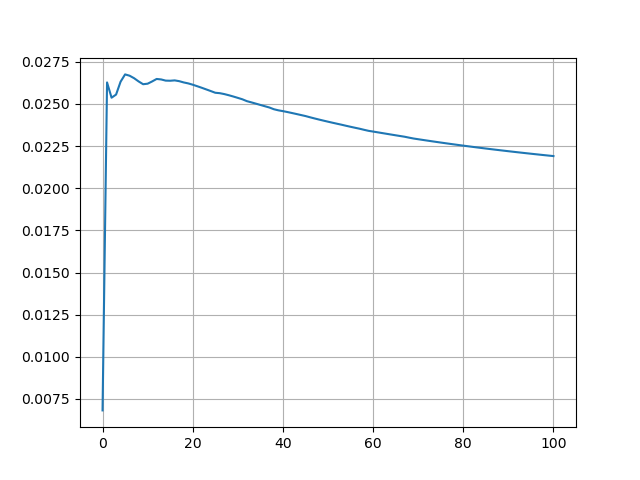

In [14]:
plt.close('all')
plt.plot(meanmu)
plt.grid()

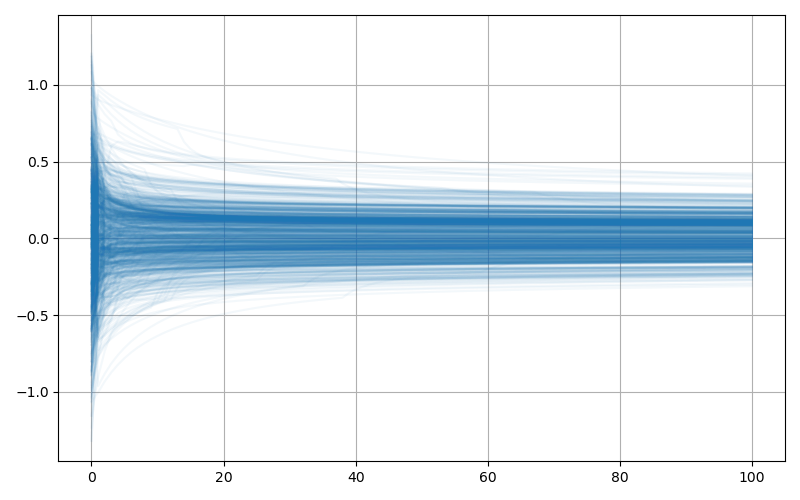

In [15]:
fig, ax = plt.subplots(figsize = (8,5), layout='tight')
for i in range(1000):
  ax.plot([mu[i] for mu in mus],alpha=0.05, color='C0')

#ax.plot( np.array(mus)[:,0] )

ax.grid()

(array([ 2.,  0.,  0.,  1.,  0.,  0.,  2.,  0.,  0.,  3.,  2.,  2.,  2.,
         3.,  1.,  0.,  5.,  7.,  2.,  6.,  2.,  6.,  3.,  5.,  5.,  6.,
         7., 16.,  8., 10.,  7., 13., 18., 15.,  9., 15., 23., 19., 27.,
        14., 12., 20., 23., 20., 20., 20., 16., 26., 35., 34., 23., 27.,
        29., 26., 24., 28., 13., 22., 26., 18., 16., 29., 30., 21., 13.,
        17., 16., 10.,  5., 11.,  7.,  5.,  6., 10., 16.,  6.,  6.,  6.,
         5.,  2.,  5.,  2.,  2.,  3.,  2.,  2.,  5.,  2.,  1.,  0.,  2.,
         0.,  2.,  2.,  2.,  2.,  0.,  0.,  0.,  1.]),
 array([-1.32134484, -1.29489008, -1.26843531, -1.24198055, -1.21552579,
        -1.18907102, -1.16261626, -1.1361615 , -1.10970673, -1.08325197,
        -1.05679721, -1.03034244, -1.00388768, -0.97743292, -0.95097816,
        -0.92452339, -0.89806863, -0.87161387, -0.8451591 , -0.81870434,
        -0.79224958, -0.76579481, -0.73934005, -0.71288529, -0.68643052,
        -0.65997576, -0.633521  , -0.60706624, -0.58061147, -0.554156

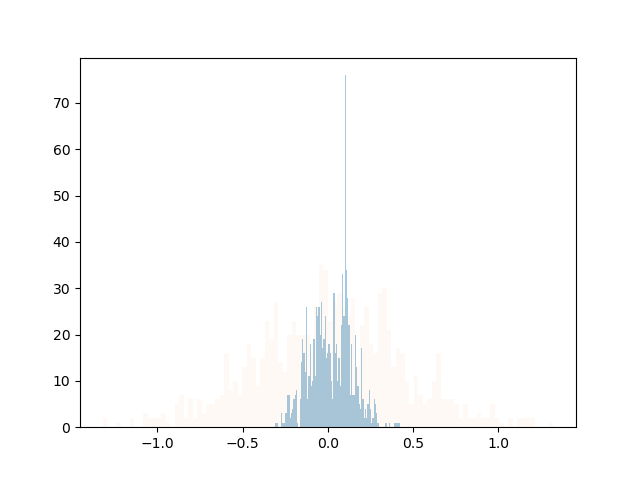

In [16]:
plt.close('all')
plt.hist(mus[-1],bins=100,alpha=0.4)
plt.hist(mus[0],bins=100,alpha=0.04)

In [20]:
np.min(mus[-1])

np.float64(-0.37732368996637217)

#### Salvataggio medie, varianze e grafo
metto una stringa con data e ora prima per identificare le simulazioni; la cartella definita sopra identifica il setup.

`*outputdir*/MESE_GIORNO_ORE_MINUTI_mus.npy`

si riaprono con `np.load(*path*)`

In [17]:
import datetime
datestr = datetime.datetime.now().strftime("%m_%d_%H_%M")
datestr

'05_26_12_43'

In [18]:
np.save(outputdir+datestr+"_mus.npy",mus)
np.save(outputdir+datestr+"_sigma2s.npy",sigma2s)

Per salvare il grafo, la roba più easy mi sembra salvare la edgelist in un file csv; ogni riga è un link, tipo:
```
0,1
1,0
0,2
2,0
```
eccetra; si può caricare in networkx con `graph = nx.read_edgelist(*filepath*, delimiter=',',nodetype=int)`.

In [19]:
netlogo.command( f"csv:to-file \"{outputdir}{datestr}_edgelist.csv\" [ [ (who) ] of both-ends ] of links" )

Per averla in python direttamente:

In [ ]:
edgelist = netlogo.report( "[ [ (who) ] of both-ends ] of links" ).astype(int)
edgelist

array([[301, 375],
       [657, 669],
       [ 27, 665],
       ...,
       [313, 942],
       [173, 424],
       [ 54, 551]], shape=(999, 2))

In [27]:
netlogo.kill_workspace()

### Simulazioni multiple

In [ ]:
num_sim = 10 #numero di simulazioni da effettuare
iters = 100  #iterazioni per ogni simulazione

muzeros = [] # liste che conterranno tutte le mu di tutte le simulazioni
sigma2zeros = []
mufinals = []
sigma2finals = []
edgelists = []

In [ ]:
import sys
if (sys.platform == 'linux') :
    netlogo = pynetlogo.NetLogoLink(
        gui=nl_gui,
        netlogo_home="/opt/netlogo/",
    )
else:
    netlogo = pynetlogo.NetLogoLink(
    gui=nl_gui,
)

netlogo.load_model(nl_model)

NetLogo Startup Error
org.picocontainer.PicoCompositionException: Duplicate Keys not allowed. Duplicate for 'class org.nlogo.compile.Compiler'
	at org.picocontainer.DefaultPicoContainer.addAdapterInternal(DefaultPicoContainer.java:438)
	at org.picocontainer.DefaultPicoContainer.addComponent(DefaultPicoContainer.java:548)
	at org.picocontainer.DefaultPicoContainer.addComponent(DefaultPicoContainer.java:501)
	at org.picocontainer.DefaultPicoContainer.addComponent(DefaultPicoContainer.java:488)
	at org.nlogo.util.Pico.add(Pico.scala:11)
	at org.nlogo.app.App$.mainWithAppHandler(App.scala:86)
	at org.nlogo.app.App$.main(App.scala:68)
	at org.nlogo.app.App.main(App.scala)
	at netLogoLink.NetLogoLink.<init>(NetLogoLink.java:44)


: 

In [53]:
def values(var: str):
  '''
  Restituisce un array con i valori di una variabile per tutti i nodi.
  '''
  return netlogo.report(f"map [s -> [{var}] of s] sort nodes")

In [ ]:
for sim in range(num_sim):
  netlogo.command('clear-all')
  for name in global_vars:
    netlogo.command(f'set {name} {global_vars[name]}')

  netlogo.command('setup')

  muzeros.append(values('mu0'))
  sigma2zeros.append(values('var0'))
  edgelists.append( netlogo.report("[ [ (who) ] of both-ends ] of links").astype(int) )

  for n in range(1,iters+1):
    netlogo.command('go')
    #mus.append(values('mu'))
    #sigma2s.append(values('var'))
    print(f"\rSimulazione {sim}, timestep {n}/{iters}",end="",flush=True)
  print()
  mufinals.append(values('mu'))
  sigma2finals.append(values('var'))

Simulazione 0, timestep 100/100
Simulazione 1, timestep 100/100
Simulazione 2, timestep 100/100
Simulazione 3, timestep 100/100
Simulazione 4, timestep 100/100
Simulazione 5, timestep 100/100
Simulazione 6, timestep 100/100
Simulazione 7, timestep 100/100
Simulazione 8, timestep 100/100
Simulazione 9, timestep 100/100


In [82]:
netlogo.kill_workspace()

In [83]:
amus = np.array(mufinals)
asigma2s = np.array(sigma2finals)

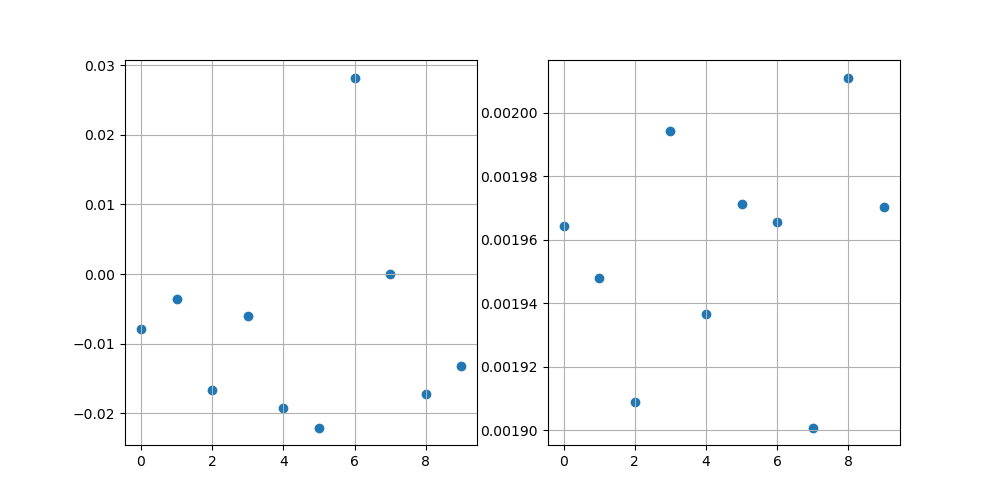

In [87]:
fig, ax = plt.subplots(ncols=2, figsize =(10,5))
ax[0].scatter(np.arange(10),np.mean(amus,axis=1))
ax[1].scatter(np.arange(10),np.mean(asigma2s,axis=1))


for a in ax:
  a.grid()

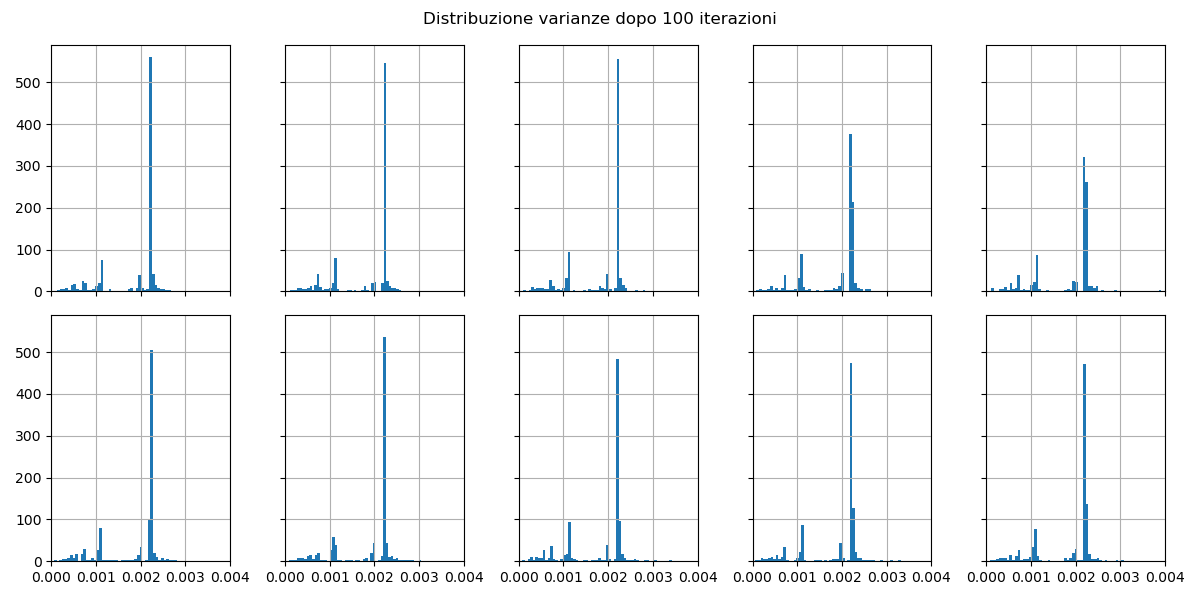

In [115]:
fig1,ax1 = plt.subplots(ncols=5,nrows=2,figsize = (12,6),sharey='all', sharex='all',layout='tight')
fig1.suptitle('Distribuzione varianze dopo 100 iterazioni')
for i,a in enumerate(ax1.flatten()):
  a.hist(asigma2s[i],bins=300)
  a.set_xlim((0,0.004))
  a.grid()

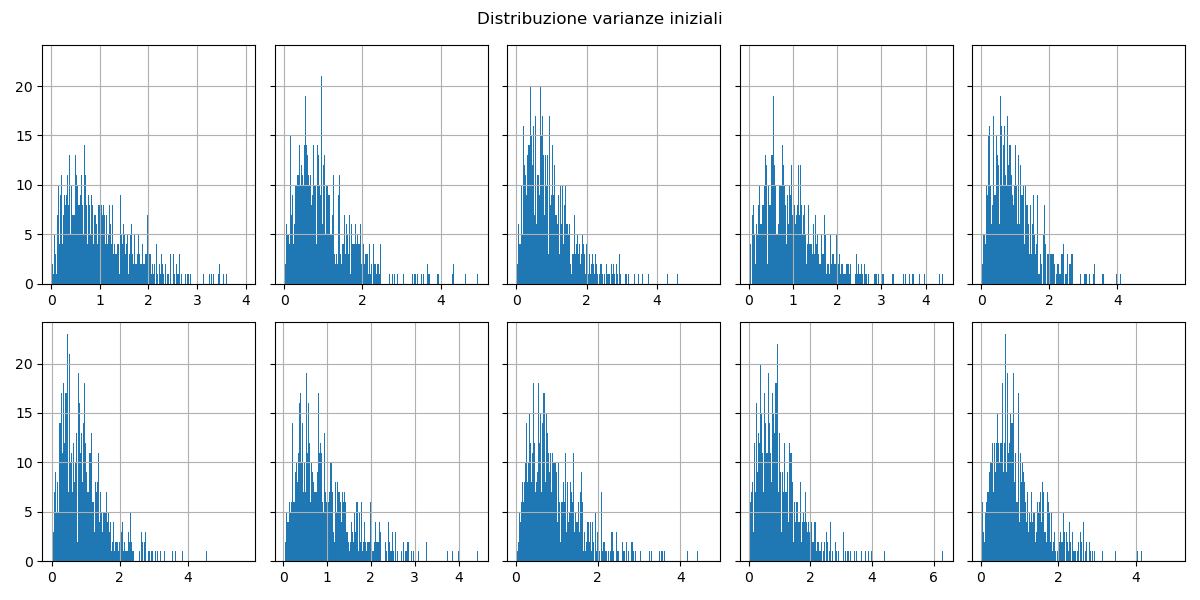

In [116]:
fig2,ax2 = plt.subplots(ncols=5,nrows=2,figsize = (12,6),sharey='all',layout='tight')
fig2.suptitle('Distribuzione varianze iniziali')
for i,a in enumerate(ax2.flatten()):
  a.hist(sigma2zeros[i],bins=300)
  #a.set_xlim((0,0.004))
  a.grid()

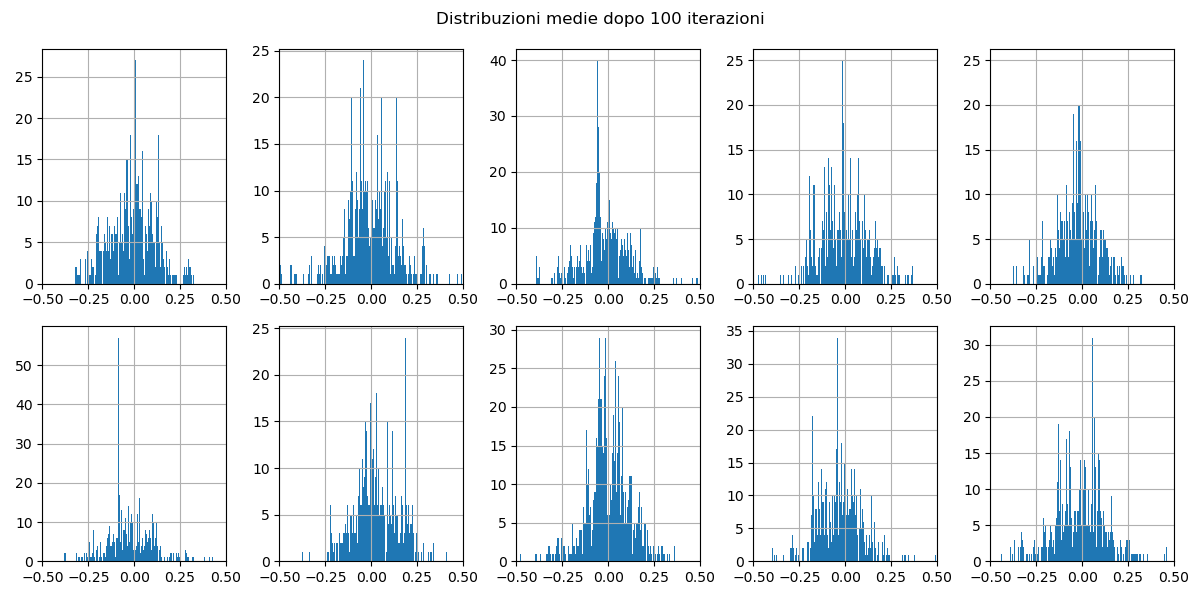

In [118]:
fig3,ax3 = plt.subplots(ncols=5,nrows=2,figsize = (12,6),sharey='none',layout='tight')
fig3.suptitle("Distribuzioni medie dopo 100 iterazioni")
for i,a in enumerate(ax3.flatten()):
  a.hist(amus[i],bins=300)
  a.set_xlim((-0.50,0.5))
  a.grid()

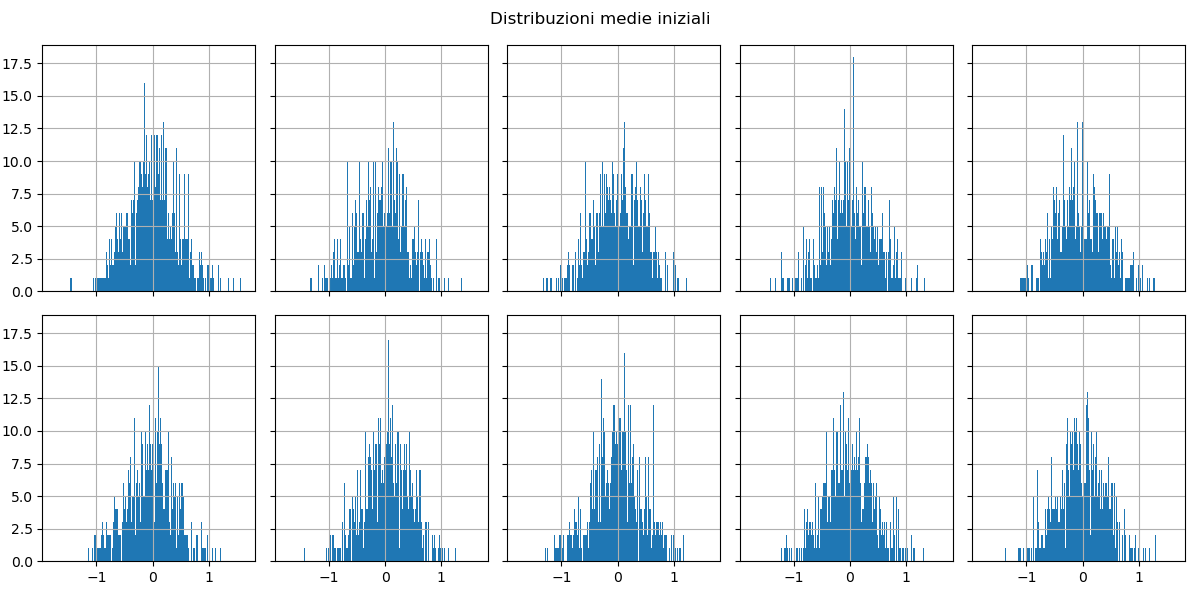

In [119]:
fig4,ax4 = plt.subplots(ncols=5,nrows=2,figsize = (12,6),sharey='all',sharex='all',layout='tight')
fig4.suptitle("Distribuzioni medie iniziali")
for i,a in enumerate(ax4.flatten()):
  a.hist(muzeros[i],bins=300)
  #a.set_xlim((-0.50,0.5))
  a.grid()

In [120]:
fig1.savefig(outputdir+'finalsigmas.png')
fig2.savefig(outputdir+'initialsigmas.png')
fig3.savefig(outputdir+'finalmus.png')
fig4.savefig(outputdir+'initialmus.png')


In [121]:
plt.close('all')

In [137]:
datestr = (datetime.datetime.now()).strftime("%m_%d_%H_%M_")
np.save(outputdir+datestr+"10mus.npy", np.stack([np.array(muzeros),amus]) )
np.save(outputdir+datestr+"10sigma2s.npy", np.stack([np.array(sigma2zeros),asigma2s]))